In [1]:
%pylab inline
import pandas as pd
import anndata
from scipy import optimize

Populating the interactive namespace from numpy and matplotlib


Data available at https://figshare.com/projects/Zero_inflation_in_negative_control_data/61292

In [2]:
zheng = anndata.read('zheng_gemcode_control.h5ad')
macos = anndata.read('macosko_dropseq_control.h5ad')
klein = anndata.read('klein_indrops_control_GSM1599501.h5ad')
svens = anndata.read('svensson_chromium_control.h5ad')

sven1 = svens[svens.obs.query('sample == "20311"').index]
sven2 = svens[svens.obs.query('sample == "20312"').index]

zheng.uns['name'] = 'Zheng et al 2017'
macos.uns['name'] = 'Macosko et al 2015'
klein.uns['name'] = 'Klein et al 2015'
sven1.uns['name'] = 'Svensson et al 2017 (1)'
sven2.uns['name'] = 'Svensson et al 2017 (2)'

In [3]:
datasets = [klein, macos, zheng, sven1, sven2]

In [4]:
for adata in datasets:
    mean_ = np.array(adata.X.mean(0))
    var_ = np.array(adata.X.power(2).mean(0) - mean_ ** 2)
    frac_zero = np.array(1 - (adata.X > 0).sum(0) / adata.shape[0])
    adata.var['mean_'] = mean_[0]
    adata.var['var_'] = var_[0]
    adata.var['frac_zero'] = frac_zero[0]

In [5]:
var_fun = lambda mu, phi: mu + phi * mu ** 2

for adata in datasets:
    phi_hat, _ = optimize.curve_fit(var_fun, adata.var['mean_'], adata.var['var_'])
    adata.uns['phi_hat'] = phi_hat

In [6]:
xx = np.logspace(-4, 4, num=128)

def prob_zero_fun(mu, phi):
    if phi == .0:
        return np.exp(-mu)
    
    phi_1 = 1. / phi
    return (phi_1 / (mu + phi_1)) ** phi_1

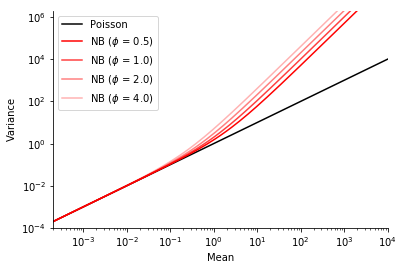

In [7]:
figsize(6, 4)
plt.loglog()

for phi in [0., 0.5, 1.0, 2.0, 4.0]:
    c = 'r'
    label = f'NB ($ \phi $ = {phi})'
    alpha = 1.5 / (1. + phi)
    if phi == 0:
        c = 'k'
        label = 'Poisson'
        alpha = 1.0

    yy = var_fun(xx, phi)
    plt.plot(xx, yy, c=c, label=label, alpha=alpha)
    
plt.xlim(left=2e-4, right=1e4)
plt.ylim(bottom=1e-4, top=2e6);
plt.legend();

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xlabel('Mean')
plt.ylabel('Variance');

plt.savefig('NB_variance_theory.pdf')

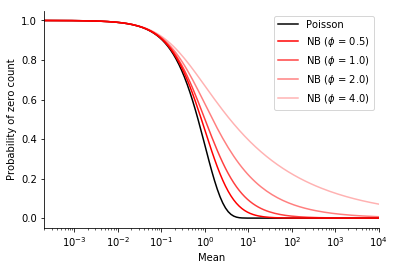

In [8]:
figsize(6, 4)
plt.xscale('log')

for phi in [0., 0.5, 1.0, 2.0, 4.0]:
    c = 'r'
    label = f'NB ($ \phi $ = {phi})'
    alpha = 1.5 / (1. + phi)
    if phi == 0:
        c = 'k'
        label = 'Poisson'
        alpha = 1.0

    yy = prob_zero_fun(xx, phi)
    plt.plot(xx, yy, c=c, label=label, alpha=alpha)
    
plt.xlim(left=2e-4, right=1e4)
plt.legend();

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xlabel('Mean')
plt.ylabel('Probability of zero count');

plt.savefig('NB_zeros_theory.pdf')

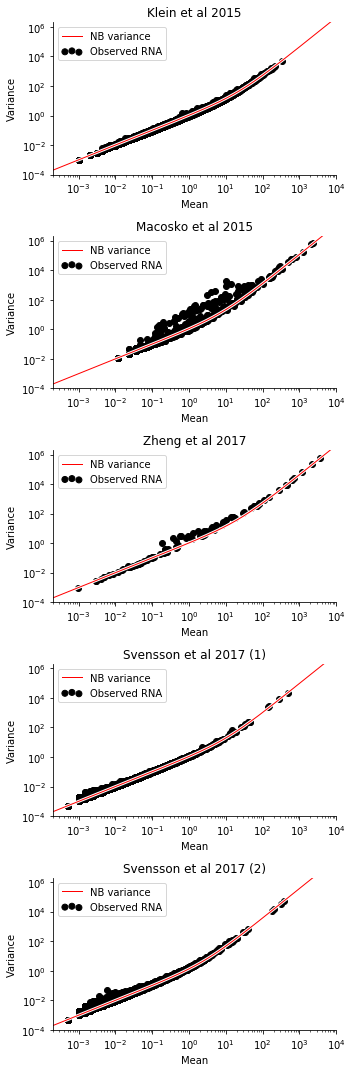

In [9]:
figsize(5, 15)
for i, adata in enumerate(datasets):
    yy = var_fun(xx, adata.uns['phi_hat'])
    plt.subplot(5, 1, i + 1)
    plt.loglog()
    plt.scatter(adata.var['mean_'], adata.var['var_'], c='k', label='Observed RNA', rasterized=True)
    plt.plot(xx, yy, lw=3, c='w')
    plt.plot(xx, yy, lw=1, c='r', label='NB variance')
    plt.xlim(left=2e-4, right=1e4)
    plt.ylim(bottom=1e-4, top=2e6);
    plt.title(adata.uns['name'])
    plt.xlabel('Mean')
    plt.ylabel('Variance');
    
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.legend(scatterpoints=3)
    
    adata.uns['var_corr'] = \
    var_fun(adata.var['mean_'], adata.uns['phi_hat']) \
        .corr(adata.var['var_'], method='spearman')
    
    
plt.tight_layout()
plt.savefig('mean_variance.pdf', dpi=300)

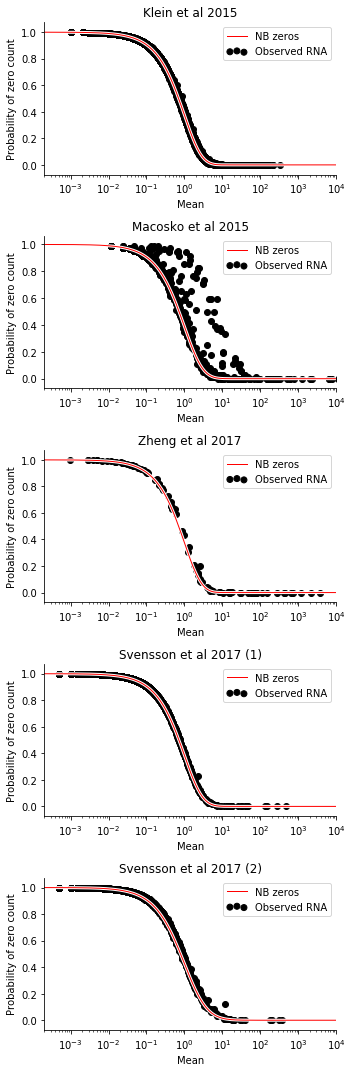

In [10]:
figsize(5, 15)
for i, adata in enumerate(datasets):
    yy = prob_zero_fun(xx, adata.uns['phi_hat'])
    plt.subplot(5, 1, i + 1)
    plt.xscale('log')
    plt.scatter(adata.var['mean_'], adata.var['frac_zero'], c='k', label='Observed RNA', rasterized=True)
    plt.plot(xx, yy, lw=3, c='w')
    plt.plot(xx, yy, lw=1, c='r', label='NB zeros')
    plt.xlim(left=2e-4, right=1e4)
    plt.title(adata.uns['name'])
    plt.xlabel('Mean')
    plt.ylabel('Probability of zero count');
    
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.legend(scatterpoints=3)
    
    adata.uns['zero_corr'] = \
    prob_zero_fun(adata.var['mean_'], adata.uns['phi_hat']) \
        .corr(adata.var['frac_zero'], method='spearman')
    
    
plt.tight_layout()
plt.savefig('mean_zeros.pdf', dpi=300)

In [11]:
for adata in datasets:
    print(adata.uns['name'] + ' - ')
    print('\tShape : ' + str(adata.shape))
    print('\tPhi: ' + str(adata.uns['phi_hat']))
    print('\tObserved genes: ' + str((adata.var.frac_zero < 1.).sum()))
    print('\tCorr. Obs vs Exp variance: ' + str(adata.uns['var_corr']))
    print('\tCorr. Obs vs Exp frac zeros: ' + str(adata.uns['zero_corr']))

Klein et al 2015 - 
	Shape : (953, 25435)
	Phi: [0.04279368]
	Observed genes: 25266
	Corr. Obs vs Exp variance: 0.9994836065068071
	Corr. Obs vs Exp frac zeros: 0.9998241849223161
Macosko et al 2015 - 
	Shape : (84, 959)
	Phi: [0.11569797]
	Observed genes: 959
	Corr. Obs vs Exp variance: 0.9921433990072973
	Corr. Obs vs Exp frac zeros: 0.9798729630138682
Zheng et al 2017 - 
	Shape : (1015, 92)
	Phi: [0.04157537]
	Observed genes: 91
	Corr. Obs vs Exp variance: 0.9957923290922681
	Corr. Obs vs Exp frac zeros: 0.9914454630613294
Svensson et al 2017 (1) - 
	Shape : (2000, 24116)
	Phi: [0.09397924]
	Observed genes: 20647
	Corr. Obs vs Exp variance: 0.9995196151327608
	Corr. Obs vs Exp frac zeros: 0.9997789277425738
Svensson et al 2017 (2) - 
	Shape : (2000, 24116)
	Phi: [0.36921976]
	Observed genes: 21411
	Corr. Obs vs Exp variance: 0.9973451627372089
	Corr. Obs vs Exp frac zeros: 0.9984910580440239
